In [1]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import random
from matplotlib import pyplot as plt
import matplotlib as mpl

2024-07-22 07:25:03.506657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
sys.path

['/Users/noahhood/Desktop/stonks',
 '/Users/noahhood/miniforge3/lib/python39.zip',
 '/Users/noahhood/miniforge3/lib/python3.9',
 '/Users/noahhood/miniforge3/lib/python3.9/lib-dynload',
 '',
 '/Users/noahhood/miniforge3/lib/python3.9/site-packages',
 '/Users/noahhood/miniforge3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/noahhood/.ipython']

In [3]:
# Replace 'your_file.csv' with the actual filename
filename = 'nasdaq_screener_1704330957680.csv'

# Load the CSV file using pandas
stocks = pd.read_csv(filename)

# Print the loaded data
print(stocks)


     Symbol                                               Name Last Sale  \
0         A             Agilent Technologies Inc. Common Stock   $131.16   
1        AA                    Alcoa Corporation Common Stock     $31.49   
2      AACG   ATA Creativity Global American Depositary Shares     $1.04   
3      AACI            Armada Acquisition Corp. I Common Stock    $10.83   
4     AACIW                 Armada Acquisition Corp. I Warrant    $0.025   
...     ...                                                ...       ...   
7259   ZVRA               Zevra Therapeutics Inc. Common Stock     $6.42   
7260   ZVSA             ZyVersa Therapeutics Inc. Common Stock   $0.9181   
7261    ZWS  Zurn Elkay Water Solutions Corporation Common ...    $28.18   
7262   ZYME                        Zymeworks Inc. Common Stock    $10.67   
7263   ZYXI                            Zynex Inc. Common Stock    $10.61   

      Net Change % Change    Market Cap        Country  IPO Year   Volume  \
0        -

In [4]:
datetime.now().hour

7

In [5]:
def get_weekday_dates(start_date, end_date):
    weekdays = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
            weekdays.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(days=1)
    return weekdays

In [6]:
def get_weekday_dates_after(start_date, end_date):
    weekdays = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
            weekdays.append((current_date+timedelta(days=1)).strftime("%Y-%m-%d"))
        current_date += timedelta(days=1)
    return weekdays

In [7]:
start_date = datetime(2024, 5, 15)  # Start date
end_date = datetime(2024, 6, 30)    # End date
weekday_dates = get_weekday_dates(start_date, end_date)
weekday_dates_after = get_weekday_dates_after(start_date, end_date)


In [8]:
len(weekday_dates), len(weekday_dates_after)

(33, 33)

In [9]:
test = yf.download(stocks['Symbol'].iloc[2], start=weekday_dates[1], end=weekday_dates[2], interval='15m')
dtypes = [name for name in test]
test, dtypes

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AACG']: Exception('%ticker%: 15m data not available for startTime=1715832000 and endTime=1715918400. The requested range must be within the last 60 days.')


(Empty DataFrame
 Columns: [Open, High, Low, Close, Adj Close, Volume]
 Index: [],
 ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

In [10]:
# symbols = list(stocks[stocks['Country'] == 'United States']['Symbol'].values[:500])
symbols = list(stocks[stocks['Country'] == 'United States']['Symbol'].values)
intervals = 3
for i in tqdm(range(intervals)):
    if i == 0:
        data = yf.download(symbols[:(i+1)*(len(symbols)//intervals)], start_date, end_date, interval='15m')        
    elif (i+1)*(len(symbols)//intervals) < len(symbols):
        data = pd.concat([data, yf.download(symbols[i*len(symbols)//intervals:(i+1)*(len(symbols)//intervals)], start_date, end_date, interval='15m')], axis=1).sort_index(axis=1)
    else:
        data = pd.concat([data, yf.download(symbols[i*len(symbols)//intervals:], start_date, end_date, interval='15m')], axis=1).sort_index(axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

[****                   9%%                      ]  166 of 1871 completed

Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)


[***********           23%%                      ]  433 of 1871 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[*************         27%%                      ]  499 of 1871 completed

Failed to get ticker 'CRD/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************54%%                      ]  1006 of 1871 completed

Failed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************59%%**                    ]  1097 of 1871 completed

Failed to get ticker 'BF/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************69%%*******               ]  1283 of 1871 completed

Failed to get ticker 'BF/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************81%%*************         ]  1509 of 1871 completed

Failed to get ticker 'BIO/B' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1871 of 1871 completed


1871 Failed downloads:
['AGYS', 'CHCO', 'ERNA', 'CRIS', 'BKYI', 'AVXL', 'APPS', 'EW', 'CWST', 'AVNW', 'ATNFW', 'AAOI', 'ARMP', 'AEP', 'ECCV', 'CSL', 'BRACR', 'ATLX', 'ANSCU', 'BTA', 'BEEM', 'CRMD', 'AWRE', 'CNFRZ', 'CTRE', 'ACI', 'AWI', 'AMBA', 'ENS', 'BDJ', 'CHX', 'ACTG', 'BPOPM', 'DDT', 'CETXP', 'ENSV', 'CONXU', 'AOGO', 'EXPE', 'AZO', 'CFBK', 'BHFAO', 'BURL', 'CAT', 'AONCW', 'EVA', 'ARE', 'CRDF', 'CRVS', 'ADUS', 'ELYM', 'ALT', 'CHCI', 'COUR', 'ADBE', 'BFZ', 'EMO', 'ATMV', 'BR', 'DZSI', 'CDZI', 'ADT', 'DXYN', 'CBU', 'CR', 'BHFAL', 'BACK', 'EMCG', 'ACR', 'EME', 'ETON', 'BAFN', 'EVGOW', 'ATLCP', 'BKT', 'CABA', 'BHAC', 'AMRK', 'ESCA', 'ETY', 'EAST', 'CASI', 'AMCX', 'AL', 'AVNT', 'CWT', 'ARRW', 'EB', 'AIN', 'ADTHW', 'BELFA', 'DC', 'CARA', 'EQT', 'BIOR', 'EDR', 'DSGN', 'BHK', 'ESLA', 'CDXS', 'ARC', 'CNK', 'ANGO', 'BAERW', 'COFS', 'CTCX', 'BOCN', 'AE', 'AIZN', 'CXH', 'AMR', 'ANIX', 'DDS', 'BKU', 'DAKT', 'ENVX', 'DEA', 'BOF', 'CDW', 'AIRC', 'A', 'BX', 'COLM', 'DNLI', 'ACXP', 'CNDT', 'CXDO',

 33%|███▎      | 1/3 [04:08<08:17, 248.59s/it]

[******                13%%                      ]  238 of 1871 completed

Failed to get ticker 'HEI/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************61%%***                   ]  1147 of 1871 completed

Failed to get ticker 'HVT/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1871 of 1871 completed


1870 Failed downloads:
['GOOG', 'GECC', 'MEG', 'FGB', 'GSHD', 'LEU', 'KAI', 'MTZ', 'MSBI', 'HESM', 'LCID', 'OGN', 'MEI', 'FR', 'FPAY', 'FLUX', 'FSCO', 'IOT', 'GDO', 'LWLG', 'IDT', 'NTRA', 'JSPRW', 'OLPX', 'HIW', 'IONS', 'LIFWZ', 'LPSN', 'KKRS', 'LBBBR', 'HBNC', 'GNRC', 'GHIXU', 'GFS', 'KTH', 'IROQ', 'LUCY', 'HWKN', 'OLB', 'MRTN', 'IGC', 'GNT', 'FDMT', 'GLV', 'HTIBP', 'GLSTW', 'ISSC', 'GNW', 'HGTY', 'GBAB', 'KRC', 'NRBO', 'LVWR', 'MYN', 'LTRN', 'LGL', 'LEO', 'MMLP', 'LRCX', 'FMBH', 'NPK', 'GERN', 'LANDM', 'LIFWW', 'MCACR', 'FTV', 'ODFL', 'HTLD', 'MTTR', 'NCPLW', 'FMNB', 'NUW', 'HNNA', 'OFLX', 'IBOC', 'IP', 'HYMC', 'HSPOW', 'HUMA', 'LNTH', 'HOWL', 'MBINO', 'LVO', 'IPX', 'HPP', 'MAQC', 'GRF', 'HZO', 'KITTW', 'LGMK', 'GIII', 'HFRO', 'NUV', 'IVAC', 'KMPB', 'INFU', 'HXL', 'MBCN', 'HEPA', 'MPC', 'HUBB', 'FULC', 'NDSN', 'NUTX', 'MEDP', 'GCO', 'FVCB', 'GWRE', 'HURN', 'MYRG', 'IDA', 'NYMT', 'MMU', 'ODP', 'LKQ', 'NZF', 'JNPR', 'MSGS', 'ISRG', 'IIM', 'MLR', 'FHTX', 'LFVN', 'GATO', 'IIIV', 'LEN', 

 67%|██████▋   | 2/3 [08:19<04:09, 249.98s/it]

[**********************62%%****                  ]  1153 of 1870 completed

Failed to get ticker 'WSO/B' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1870 of 1870 completed


1870 Failed downloads:
['WINVR', 'SBUX', 'PAYO', 'SKIN', 'SCOR', 'XPRO', 'PFC', 'WGO', 'TCI', 'PD', 'SRM', 'PUMP', 'UBX', 'RILYP', 'OTLK', 'XLO', 'XMTR', 'PAY', 'SM', 'PINE', 'VTR', 'ZTS', 'RDZN', 'PTGX', 'VCSA', 'SNPO', 'TLYS', 'SRZNW', 'PLPC', 'VLT', 'PIK', 'TNGX', 'PWUPU', 'PFD', 'ZIMV', 'TGI', 'RGTI', 'SNES', 'SUPN', 'STE', 'VSACW', 'SFM', 'PKST', 'WMS', 'RWAY', 'SEER', 'WHG', 'YUM', 'PBH', 'QVCC', 'PINC', 'VECO', 'TRI', 'QOMO', 'RENB', 'TDG', 'SHPWW', 'PTWO', 'PNNT', 'TBBK', 'TRONU', 'YOTAW', 'WTRG', 'RNA', 'SRRK', 'VRCA', 'PDM', 'WRBY', 'TGNA', 'SMHI', 'OXLCM', 'RVMDW', 'UMBF', 'SPRY', 'PSMT', 'RDZNW', 'VLY', 'PCYO', 'SEB', 'SEEL', 'OMIC', 'ORIC', 'SCI', 'UHG', 'SFNC', 'SOFI', 'WELL', 'OPY', 'VERY', 'PEBO', 'SWN', 'SSIC', 'VEEE', 'STRT', 'PHT', 'OUT', 'PRPO', 'RUSHA', 'UNFI', 'STIXW', 'POST', 'TURN', 'POLA', 'TUP', 'TWN', 'PTWOU', 'VLD', 'SCLXW', 'TMTCR', 'TRDA', 'WSBF', 'VRPX', 'VGZ', 'VSTS', 'PLAY', 'RILY', 'USGO', 'SEMR', 'RNXT', 'TPST', 'PANW', 'W', 'SHBI', 'VVOS', 'VRNT', '

100%|██████████| 3/3 [12:36<00:00, 252.13s/it]


In [11]:
data

Adj Close                                               \
                            A  AA AACI AACIW AADI AAGR AAGRW AAIN AAL AAMC   
2024-05-29 09:30:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-05-29 09:45:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-05-29 10:00:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-05-29 10:15:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-05-29 10:30:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
...                       ...  ..  ...   ...  ...  ...   ...  ...  ..  ...   
2024-06-28 14:45:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-06-28 15:00:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-06-28 15:15:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-06-28 15:30:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   
2024-06-28 15:45:00       NaN NaN  NaN   NaN  NaN  NaN   NaN  NaN NaN  NaN   

                     ... Volume                                          
                     ...    ZOM  ZS ZTR ZTS ZUMZ ZUO ZVIA ZVRA ZVSA ZWS  
2024-05-29 09:30:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-05-29 09:45:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-05-29 10:00:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-05-29 10:15:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-05-29 10:30:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
...                  ...    ...  ..  ..  ..  ...  ..  ...  ...  ...  ..  
2024-06-28 14:45:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-06-28 15:00:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-06-28 15:15:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-06-28 15:30:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  
2024-06-28 15:45:00  ...    NaN NaN NaN NaN  NaN NaN  NaN  NaN  NaN NaN  

[513 rows x 33672 columns]

In [12]:
data.shape

(806, 33672)

In [12]:
data.shape

(513, 33672)

In [13]:
dates = np.unique([i.date() for i in data['Open'].index])

In [14]:
# data = data['Open']

In [15]:
# dates = np.unique([i.date() for i in data.index])

In [16]:
data.shape, data.shape[0]/26

((513, 33672), 19.73076923076923)

In [17]:
full_dataset = [True if np.isnan(data[name]).sum() == 0 else False for name in data.columns]

In [18]:
data.columns[full_dataset]

MultiIndex([('Adj Close', 'INBX'),
            (    'Close', 'INBX'),
            (     'High', 'INBX'),
            (      'Low', 'INBX'),
            (     'Open', 'INBX'),
            (   'Volume', 'INBX')],
           )

In [19]:
data = data[data.columns[full_dataset]]

In [20]:
data

,Adj Close,Close,High,Low,Open,Volume
,INBX,INBX,INBX,INBX,INBX,INBX
2024-05-29 09:30:00,34.455002,34.455002,34.490002,34.250000,34.345001,2543
2024-05-29 09:45:00,34.395000,34.395000,34.450001,34.395000,34.450001,4161
2024-05-29 10:00:00,34.330002,34.330002,34.397999,34.320000,34.369999,28554
2024-05-29 10:15:00,34.345001,34.345001,34.360001,34.314999,34.349998,17330
2024-05-29 10:30:00,34.299999,34.299999,34.359001,34.299999,34.340000,14960
...,...,...,...,...,...,...
2024-06-28 14:45:00,14.160000,14.160000,14.160000,14.080000,14.080000,1321
2024-06-28 15:00:00,14.100000,14.100000,14.160000,14.070000,14.150000,5919
2024-06-28 15:15:00,14.150000,14.150000,14.150000,13.980000,13.995000,6235


In [21]:
data.shape

(513, 6)

In [22]:
input_length = test.shape[0]
n_features = 6
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Add a fully connected layer (optional, depending on what you want as the final output)
model.add(Dense(128, activation='relu'))

# The output layer can be a Dense layer or simply return the output from the last layer (for feature extraction)
# For feature extraction, you may not need a final Dense layer, just return the flattened layer output
# model.add(layers.Dense(number_of_classes, activation='softmax'))  # If classification is needed

# Compile the model (for training purposes, you can skip this step if only feature extraction is needed)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Assuming your data is named 'data' with shape (10, 5, 6)
# 10 samples, each with a sequence of length 5, and each element having a feature vector of length 6

binary_model = Sequential()

# binary_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
binary_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
binary_model.add(MaxPooling1D(pool_size=2))
binary_model.add(Dropout(0.2))

# You can add more CNN layers if needed
binary_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
binary_model.add(MaxPooling1D(pool_size=2))
binary_model.add(Dropout(0.2))

# Flatten the output of the CNN
binary_model.add(Flatten())

# Add the LSTM layer
binary_model.add(tf.keras.layers.Reshape((-1, 128)))


# binary_model.add(LSTM(50, input_shape=(int(data.shape[0]/dates.size), n_features)))
binary_model.add(LSTM(50))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=16, activation='relu'))
# model.add(Dropout(rate=0.2))

# Output layer with a single unit (assuming a regression problem)
binary_model.add(Dense(1, activation='sigmoid'))
# binary_model.add(Dense(1, activation='softmax'))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-1,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# # Compile the model with an appropriate loss function and optimizer
# binary_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# binary_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
binary_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 64)            1216      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)           

In [24]:
pred_model = Sequential()

pred_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
pred_model.add(MaxPooling1D(pool_size=2))
pred_model.add(Dropout(0.2))

# You can add more CNN layers if needed
pred_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
pred_model.add(MaxPooling1D(pool_size=2))
pred_model.add(Dropout(0.2))

# Flatten the output of the CNN
pred_model.add(tf.keras.layers.Reshape((-1, 128)))

# pred_model.add(LSTM(50, input_shape=(int(data.shape[0]/dates.size), n_features)))
pred_model.add(LSTM(50))

# Output layer with a single unit (assuming a regression problem)
pred_model.add(Dense(1))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-1,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# # Compile the model with an appropriate loss function and optimizer
# pred_model.compile(optimizer=optimizer, loss='mean_squared_error')
pred_model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model's architecture
pred_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 24, 64)            1216      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 64)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 5, 128)           

In [25]:
dates_mask = [[True if i.date() == date else False for i in data.index] for date in dates]

In [26]:
# raw_data = [[data[name][dates_mask[i]] for name in data.columns] for i in range(len(dates))]

In [27]:
# raw_data = [[data[name][dates_mask[i]].values for name in data.columns] for i in range(len(dates))]

In [28]:
features = np.unique([i[0] for i in data.columns])
features

array(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='<U9')

In [29]:
symbols = np.unique([i[1] for i in data.columns])
symbols

array(['A', 'AA', 'AAL', ..., 'ZM', 'ZOM', 'ZS'], dtype='<U5')

In [30]:
data[('Open', 'A')]

2024-05-15 09:30:00    153.000000
2024-05-15 09:45:00    153.649994
2024-05-15 10:00:00    152.740005
2024-05-15 10:15:00    153.046005
2024-05-15 10:30:00    152.720001
                          ...    
2024-06-28 14:45:00    129.699997
2024-06-28 15:00:00    129.479996
2024-06-28 15:15:00    129.080002
2024-06-28 15:30:00    129.009995
2024-06-28 15:45:00    128.729996
Name: (Open, A), Length: 806, dtype: float64

In [31]:
raw_data = [[[data[(feature, symbol)][dates_mask[i]].values for symbol in symbols] for feature in features] for i in range(len(dates))]

In [32]:
raw_data = np.array(raw_data)

In [33]:
raw_data

array([[[[1.53634995e+02, 1.52755005e+02, 1.52970001e+02, ...,
          1.53710007e+02, 1.54199997e+02, 1.54100006e+02],
         [3.97700005e+01, 3.97000008e+01, 3.93800011e+01, ...,
          3.97999992e+01, 3.99700012e+01, 4.00400009e+01],
         [1.51204996e+01, 1.50950003e+01, 1.51650000e+01, ...,
          1.49600000e+01, 1.49499998e+01, 1.49399996e+01],
         ...,
         [6.36344986e+01, 6.34300003e+01, 6.30000000e+01, ...,
          6.38699989e+01, 6.37599983e+01, 6.38300018e+01],
         [1.56000003e-01, 1.62200004e-01, 1.65000007e-01, ...,
          1.67649999e-01, 1.68500006e-01, 1.69000000e-01],
         [1.79800797e+02, 1.78585007e+02, 1.79839996e+02, ...,
          1.82664993e+02, 1.82080002e+02, 1.81149994e+02]],

        [[1.53634995e+02, 1.52755005e+02, 1.52970001e+02, ...,
          1.53710007e+02, 1.54199997e+02, 1.54100006e+02],
         [3.97700005e+01, 3.97000008e+01, 3.93800011e+01, ...,
          3.97999992e+01, 3.99700012e+01, 4.00400009e+01],
        

In [34]:
raw_data.shape

(31, 6, 1695, 26)

In [35]:
raw_data = np.swapaxes(raw_data, 1, 2)
raw_data = np.swapaxes(raw_data, 2, 3)
raw_data.shape

(31, 1695, 26, 6)

In [36]:
features

array(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='<U9')

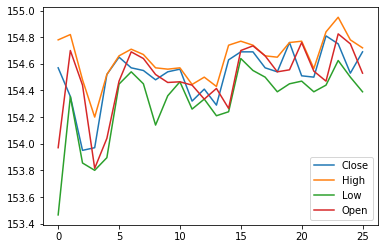

In [37]:
fig, ax = plt.subplots()
for count, feature in enumerate(features[1:-1]):
    ax.plot(np.arange(26), raw_data[3, 0, :, count+1], label=f'{feature}')
ax.legend()

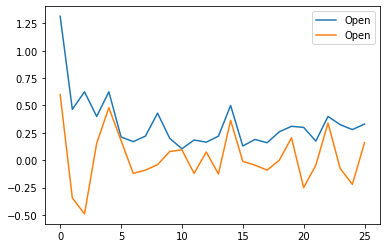

In [38]:
fig, ax = plt.subplots()
ax.plot(np.arange(26), raw_data[3, 0, :, 2] - raw_data[3, 0, :, 3], label=f'{feature}')
ax.plot(np.arange(26), raw_data[3, 0, :, 1] - raw_data[3, 0, :, 4], label=f'{feature}')
ax.legend()

In [39]:
raw_data = raw_data[:, :, :, 1:5]
raw_data.shape

(31, 1695, 26, 4)

In [40]:
features = features[1:5]
features

array(['Close', 'High', 'Low', 'Open'], dtype='<U9')

In [41]:
raw_data = np.concatenate((raw_data, 
                           np.array(raw_data[:, :, :, 0] - raw_data[:, :, :, 3]).reshape(raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 1)), axis=3)

In [42]:
raw_data = np.concatenate((raw_data, 
                           np.array(raw_data[:, :, :, 1] - raw_data[:, :, :, 2]).reshape(raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 1)), axis=3)

In [43]:
raw_data.shape

(31, 1695, 26, 6)

In [44]:
# opens = raw_data[:, :, 0]

In [45]:
opens0 = raw_data[:, :, 0, 3]
opens1 = raw_data[:, :, 1, 3]
opens2 = raw_data[:, :, 2, 3]
opens3 = raw_data[:, :, 3, 3]
close0 = raw_data[:, :, 0, 3]
close1 = raw_data[:, :, 1, 3]
close2 = raw_data[:, :, 2, 3]
close3 = raw_data[:, :, 3, 3]
highs0 = raw_data[:, :, 0, 3]
highs1 = raw_data[:, :, 1, 3]
highs2 = raw_data[:, :, 2, 3]
highs3 = raw_data[:, :, 3, 3]
lows0 = raw_data[:, :, 0, 3]
lows1 = raw_data[:, :, 1, 3]
lows2 = raw_data[:, :, 2, 3]
lows3 = raw_data[:, :, 3, 3]

In [46]:
data.shape

(806, 10170)

In [47]:
# opens = raw_data[2:, :, 0] - raw_data[1:-1, :, 0]

In [48]:
# # Define the data type for the structured array
# dtype = [('date', 'O'), ('name', 'U10'), ('data', 'O')]

# # Create the structured array
# date_data = np.array([[(dates[i], name, np.array(data[name][dates_mask[i]].values)) for name in data.columns] for i in range(len(dates))], dtype=dtype)
# # date_data = np.array(list(zip(dates, data.columns, raw_data)), dtype=dtype)

In [49]:
# date_data.shape

In [50]:
# date_data['date']

In [51]:
# pred_targets = np.divide((opens[2:] - opens[1:-1]), opens[1:-1])
# pred_targets.shape

In [52]:
pred_targets = np.divide((opens0[2:] - opens0[1:-1]), opens0[1:-1])
pred_targets.shape

(29, 1695)

In [53]:
pred_targets

array([[ 0.01271539,  0.01850004, -0.00999997, ..., -0.00031432,
         0.12958579,  0.00088996],
       [-0.00349488,  0.01816391, -0.00740745, ...,  0.00754592,
        -0.08852804, -0.00594671],
       [ 0.00246804,  0.01904535, -0.02103117, ..., -0.02075204,
         0.04252877, -0.00452867],
       ...,
       [-0.00748144, -0.00698251, -0.01162792, ...,  0.00138627,
        -0.06340818,  0.00469228],
       [-0.01335927, -0.01205423,  0.00271491, ..., -0.00614292,
         0.02256696, -0.0115385 ],
       [-0.00408467,  0.01270971,  0.01353787, ...,  0.02150251,
         0.05310353,  0.05614234]])

In [54]:
pred_targets = pred_targets.reshape(pred_targets.shape[0]*pred_targets.shape[1])

In [55]:
pred_targets

array([ 0.01271539,  0.01850004, -0.00999997, ...,  0.02150251,
        0.05310353,  0.05614234])

In [56]:
## Come up with a better classification for final states, maybe something with stability, increase across multiple data types, increase at open and after, no rapid decreases

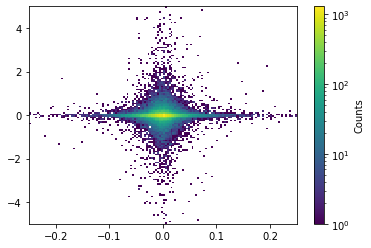

In [57]:
fig, ax = plt.subplots()
# im = ax.hist2d(pred_targets, raw_data[:-2, :, :, 5], bins=np.linspace(-70, 70, 141), cmap='viridis', norm=mpl.colors.LogNorm())
im = ax.hist2d(pred_targets, raw_data[:-2, :, 4, 4].flatten(), bins=[np.linspace(-0.25, 0.25, 141), np.linspace(-5, 5, 141)], cmap='viridis', norm=mpl.colors.LogNorm())
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label('Counts')

In [58]:
features

array(['Close', 'High', 'Low', 'Open'], dtype='<U9')

In [59]:
raw_data.shape

(31, 1695, 26, 6)

(array([0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 4.000e+00, 3.000e+00,
        6.000e+00, 6.000e+00, 3.000e+00, 1.000e+00, 5.000e+00, 5.000e+00,
        4.000e+00, 7.000e+00, 9.000e+00, 8.000e+00, 4.000e+00, 8.000e+00,
        1.000e+01, 5.000e+00, 1.100e+01, 1.000e+01, 1.500e+01, 1.600e+01,
        1.700e+01, 1.700e+01, 1.200e+01, 2.400e+01, 3.200e+01, 3.200e+01,
        3.300e+01, 3.400e+01, 6.000e+01, 5.900e+01, 6.200e+01, 8.400e+01,
        9.400e+01, 1.070e+02, 1.060e+02, 1.330e+02, 1.300e+02, 2.040e+02,
        2.580e+02, 2.380e+02, 3.600e+02, 4.320e+02, 5.000e+02, 6.050e+02,
        7.160e+02, 9.420e+02, 1.139e+03, 1.451e+03, 1.856e+03, 2.324e+03,
        2.768e+03, 3.287e+03, 3.761e+03, 3.889e+03, 4.279e+03, 3.608e+03,
        3.104e+03, 2.461e+03, 1.912e+03, 1.428e+03, 1.115e+03, 8.440e+02,
        6.990e+02, 5.340e+02, 4.660e+0

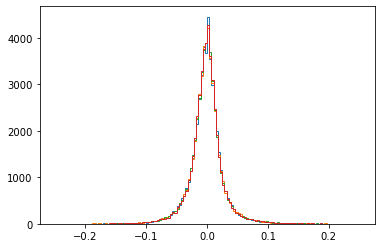

In [60]:
fig, ax = plt.subplots()
ax.hist(pred_targets, bins=np.linspace(-0.25, 0.25, 141), histtype='step')
ax.hist(np.divide((raw_data[2:, :, 1, 3] - raw_data[1:-1, :, 1, 3]), raw_data[1:-1, :, 1, 3]).flatten(), bins=np.linspace(-0.25, 0.25, 141), histtype='step')
ax.hist(np.divide((raw_data[2:, :, 2, 3] - raw_data[1:-1, :, 2, 3]), raw_data[1:-1, :, 2, 3]).flatten(), bins=np.linspace(-0.25, 0.25, 141), histtype='step')
ax.hist(np.divide((raw_data[2:, :, 3, 3] - raw_data[1:-1, :, 3, 3]), raw_data[1:-1, :, 3, 3]).flatten(), bins=np.linspace(-0.25, 0.25, 141), histtype='step')

0.24441053809378496


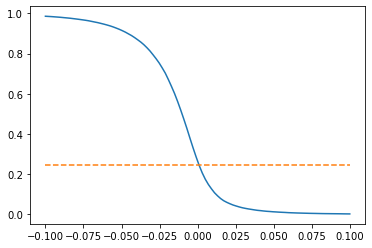

In [61]:
size = []
cond = np.full(raw_data[2:].shape[:2], True, dtype=bool)
# percent_gains = np.logspace(-5, 1, 100)
percent_gains = np.linspace(-0.1, 0.1, 100)
for percent in percent_gains:
    for i in range(4):
        for j in range(4):
            cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > percent
    size.append(cond[cond].size/cond.size)
fig, ax = plt.subplots()
ax.plot(percent_gains, size)
ax.plot(percent_gains, np.full(len(percent_gains), size[np.argmin((percent_gains-0)**2)]), linestyle='--')
print(size[np.argmin((percent_gains-0)**2)])
# ax.set_xscale('log')

0.26086868070389585


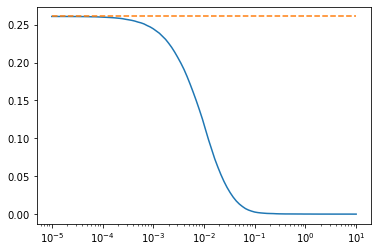

In [62]:
size = []
cond = np.full(raw_data[2:].shape[:2], True, dtype=bool)
percent_gains = np.logspace(-5, 1, 100)
# percent_gains = np.linspace(-0.1, 0.1, 100)
for percent in percent_gains:
    for i in range(4):
        for j in range(4):
            cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > percent
    size.append(cond[cond].size/cond.size)
fig, ax = plt.subplots()
ax.plot(percent_gains, size)
ax.plot(percent_gains, np.full(len(percent_gains), size[np.argmin((percent_gains-0)**2)]), linestyle='--')
print(size[np.argmin((percent_gains-0)**2)])
ax.set_xscale('log')

0.11888922795239548


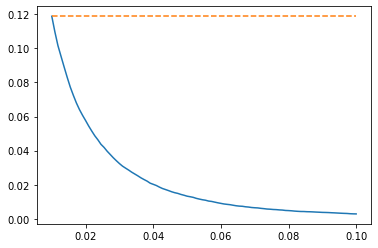

In [63]:
size = []
cond = np.full(raw_data[2:].shape[:2], True, dtype=bool)
# percent_gains = np.logspace(-5, 1, 100)
percent_gains = np.linspace(0.01, 0.1, 100)
for percent in percent_gains:
    for i in range(4):
        for j in range(4):
            cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > percent
    size.append(cond[cond].size/cond.size)
fig, ax = plt.subplots()
ax.plot(percent_gains, size)
ax.plot(percent_gains, np.full(len(percent_gains), size[np.argmin((percent_gains-0)**2)]), linestyle='--')
print(size[np.argmin((percent_gains-0)**2)])
# ax.set_xscale('log')

In [64]:
raw_data.shape

(31, 1695, 26, 6)

In [65]:
features

array(['Close', 'High', 'Low', 'Open'], dtype='<U9')

In [66]:
cond_good = np.full(raw_data[2:].shape[:2], True, dtype=bool)
for i in range(4):
    # for j in range(4):
    for j in range(1, 4):
        # cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.01
        cond_good &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.04

In [67]:
raw_data[2:][cond_good].size/raw_data[2:].size

0.02105584375953616

In [68]:
cond_good.shape, pred_targets.shape

((29, 1695), (49155,))

In [69]:
cond_good = cond_good.reshape(cond_good.shape[0]*cond_good.shape[1])

In [70]:
# binary_targets = np.array([1 if i > 0 else 0 for i in pred_targets])
binary_targets = np.array([1 if i == True else 0 for i in cond_good])

In [71]:
binary_targets.shape

(49155,)

In [72]:
cond_okay = np.full(raw_data[2:].shape[:2], True, dtype=bool)
for i in range(4):
    # for j in range(4):
    for j in range(1, 4):
        # cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.01
        cond_okay &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0
print(raw_data[2:][cond_okay].size/raw_data[2:].size)
cond_okay = cond_okay.reshape(cond_okay.shape[0]*cond_okay.shape[1])

0.26855864103346555


In [73]:
cond_bad = np.full(raw_data[2:].shape[:2], True, dtype=bool)
for i in range(4):
    # for j in range(4):
    for j in range(1, 4):
        # cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.01
        cond_bad &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) < -0.01
print(raw_data[2:][cond_bad].size/raw_data[2:].size)
cond_bad = cond_bad.reshape(cond_bad.shape[0]*cond_bad.shape[1])

0.15955650493337403


In [74]:
# binary_targets = np.array([1 if i > 0 else 0 for i in pred_targets])
binary_targets_okay = np.array([1 if i == True else 0 for i in cond_okay])

In [75]:
raw_data.shape

(31, 1695, 26, 6)

In [92]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    # counts = np.add(counts, np.divide((raw_data[2:, :, -1, i] - raw_data[1:-1, :, 0, i]), raw_data[1:-1, :, 0, i]).flatten())
    counts = np.add(counts, np.divide((raw_data[:-2, :, -1, i] - raw_data[:-2, :, 0, i]), raw_data[:-2, :, 0, i]).flatten())

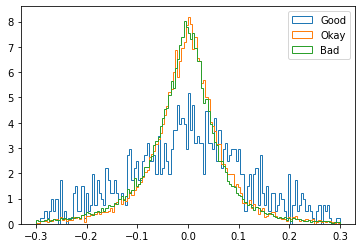

In [93]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-0.3, 0.3, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-0.3, 0.3, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-0.3, 0.3, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [94]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    for j in range(4):
        # counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]).flatten())
        counts = np.add(counts, np.divide((raw_data[:-2, :, -(i+1), j] - raw_data[:-2, :, i, j]), raw_data[:-2, :, i, j]).flatten())

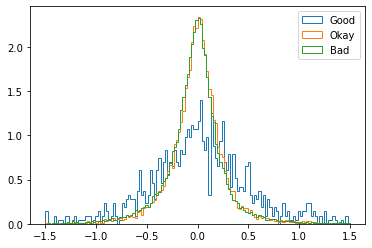

In [95]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [87]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    for j in range(4):
        counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]).flatten())
        # counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[2:, :, i, j]), raw_data[2:, :, i, j]).flatten())

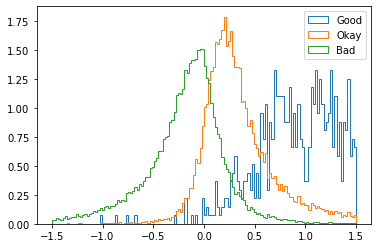

In [89]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [90]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    for j in range(4):
        counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[:-2, :, i, j]), raw_data[:-2, :, i, j]).flatten())
        # counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[2:, :, i, j]), raw_data[2:, :, i, j]).flatten())

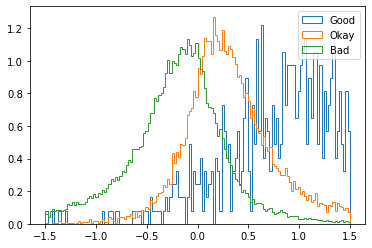

In [91]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [79]:
raw_data.shape

(31, 1695, 26, 6)

In [80]:
raw_data = raw_data[:-2]

In [81]:
raw_data.shape

(29, 1695, 26, 6)

In [82]:
# raw_data = raw_data.reshape(raw_data.shape[0]*raw_data.shape[1], raw_data.shape[2])

In [83]:
raw_data = raw_data.reshape(raw_data.shape[0]*raw_data.shape[1], raw_data.shape[2], raw_data.shape[3])

In [84]:
raw_data.shape

(49155, 26, 6)

In [85]:
pred_targets.shape, binary_targets.shape

((49155,), (49155,))

In [86]:
binary_targets[binary_targets == 1].shape, binary_targets[binary_targets == 0].shape

((1033,), (48122,))

In [87]:
binary_targets[binary_targets == 0].shape[0] - binary_targets[binary_targets == 1].shape[0]

47089

In [88]:
np.where(binary_targets == 0)[0]

array([    0,     1,     2, ..., 49152, 49153, 49154])

In [89]:
balance_mask = random.sample(list(np.where(binary_targets == 0)[0]), binary_targets[binary_targets == 0].shape[0] - binary_targets[binary_targets == 1].shape[0])

In [90]:
balance_mask = [False if i in balance_mask else True for i in range(binary_targets.shape[0])]

In [91]:
raw_data_balance = raw_data[balance_mask]
binary_targets_balance = binary_targets[balance_mask]
pred_targets_balance = pred_targets[balance_mask]

In [92]:
# binary_targets = binary_targets.ravel()
binary_targets_balance = binary_targets_balance.reshape(-1, 1)

# pred_targets = pred_targets.ravel()
pred_targets_balance = pred_targets_balance.reshape(-1, 1)

In [93]:
raw_data.shape, binary_targets.shape, pred_targets.shape

((49155, 26, 6), (49155,), (49155,))

In [94]:
raw_data_balance.shape, binary_targets_balance.shape, pred_targets_balance.shape

((2066, 26, 6), (2066, 1), (2066, 1))

In [95]:
# from sklearn.model_selection import train_test_split

# # Assuming 'data' is your input feature matrix and 'targets' is your output values
# X_train, X_test, y_train_pred, y_test_pred = train_test_split(raw_data, pred_targets, test_size=0.2, random_state=42)
# X_train, X_test, y_train_binary, y_test_binary = train_test_split(raw_data, binary_targets, test_size=0.2, random_state=42)
# # X_train_2, X_test_2, y_train_binary, y_test_binary = train_test_split(raw_data[:, :-2, -2], binary_targets, test_size=0.2, random_state=42)

In [96]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your input feature matrix and 'targets' is your output values
X_train, X_test, y_train_pred, y_test_pred = train_test_split(raw_data_balance, pred_targets_balance, test_size=0.2, random_state=42)
X_train, X_test, y_train_binary, y_test_binary = train_test_split(raw_data_balance, binary_targets_balance, test_size=0.2, random_state=42)
# X_train_2, X_test_2, y_train_binary, y_test_binary = train_test_split(raw_data[:, :-2, -2], binary_targets, test_size=0.2, random_state=42)

In [97]:
X_train.shape

(1652, 26, 6)

In [98]:
y_train_binary.T.shape

(1, 1652)

In [99]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_binary), y=y_train_binary.T[0])
class_weights = dict(enumerate(class_weights))

In [100]:
class_weights

{0: 1.0024271844660195, 1: 0.9975845410628019}

In [118]:
# Train the model
pred_model.fit(X_train, y_train_pred, epochs=50, batch_size=20, verbose=2)

Epoch 1/50
1831/1831 - 12s - loss: 0.0469 - 12s/epoch - 6ms/step
Epoch 2/50
1831/1831 - 9s - loss: 0.0459 - 9s/epoch - 5ms/step
Epoch 3/50
1831/1831 - 9s - loss: 0.0457 - 9s/epoch - 5ms/step
Epoch 4/50
1831/1831 - 10s - loss: 0.0455 - 10s/epoch - 5ms/step
Epoch 5/50
1831/1831 - 8s - loss: 0.0455 - 8s/epoch - 4ms/step
Epoch 6/50
1831/1831 - 8s - loss: 0.0457 - 8s/epoch - 4ms/step
Epoch 7/50
1831/1831 - 8s - loss: 0.0456 - 8s/epoch - 4ms/step
Epoch 8/50
1831/1831 - 9s - loss: 0.0457 - 9s/epoch - 5ms/step
Epoch 9/50
1831/1831 - 10s - loss: 0.0456 - 10s/epoch - 5ms/step
Epoch 10/50
1831/1831 - 9s - loss: 0.0456 - 9s/epoch - 5ms/step
Epoch 11/50
1831/1831 - 8s - loss: 0.0455 - 8s/epoch - 4ms/step
Epoch 12/50
1831/1831 - 8s - loss: 0.0454 - 8s/epoch - 4ms/step
Epoch 13/50
1831/1831 - 8s - loss: 0.0457 - 8s/epoch - 4ms/step
Epoch 14/50
1831/1831 - 9s - loss: 0.0456 - 9s/epoch - 5ms/step
Epoch 15/50
1831/1831 - 9s - loss: 0.0455 - 9s/epoch - 5ms/step
Epoch 16/50
1831/1831 - 9s - loss: 0.0455 -

In [105]:
# Train the model
binary_model.fit(X_train, y_train_binary, epochs=50, batch_size=20, verbose=2)
# binary_model.fit(X_train, y_train_binary, epochs=50, batch_size=20, verbose=2, class_weight=class_weights)

Epoch 1/50


83/83 - 0s - loss: 0.5627 - accuracy: 0.7185 - 344ms/epoch - 4ms/step
Epoch 2/50
83/83 - 0s - loss: 0.5627 - accuracy: 0.7252 - 353ms/epoch - 4ms/step
Epoch 3/50
83/83 - 0s - loss: 0.5593 - accuracy: 0.7276 - 445ms/epoch - 5ms/step
Epoch 4/50
83/83 - 0s - loss: 0.5583 - accuracy: 0.7288 - 366ms/epoch - 4ms/step
Epoch 5/50
83/83 - 0s - loss: 0.5589 - accuracy: 0.7203 - 314ms/epoch - 4ms/step
Epoch 6/50
83/83 - 0s - loss: 0.5654 - accuracy: 0.7161 - 328ms/epoch - 4ms/step
Epoch 7/50
83/83 - 0s - loss: 0.5612 - accuracy: 0.7228 - 308ms/epoch - 4ms/step
Epoch 8/50
83/83 - 0s - loss: 0.5562 - accuracy: 0.7343 - 307ms/epoch - 4ms/step
Epoch 9/50
83/83 - 0s - loss: 0.5613 - accuracy: 0.7149 - 308ms/epoch - 4ms/step
Epoch 10/50
83/83 - 0s - loss: 0.5575 - accuracy: 0.7282 - 308ms/epoch - 4ms/step
Epoch 11/50
83/83 - 0s - loss: 0.5531 - accuracy: 0.7246 - 300ms/epoch - 4ms/step
Epoch 12/50
83/83 - 0s - loss: 0.5543 - accuracy: 0.7264 - 303ms/epoch - 4ms/step
Epoch 13/50
83/83 - 0s - loss: 0.557

In [504]:
binary_model.save('models/binary_model_1695stocks_31days_4percent_2024_07_05.keras')

In [119]:
# Get predictions for the test data
y_pred = pred_model.predict(X_test)

287/287 [==============================] - 2s 4ms/step


In [107]:
# Get predictions for the test data
y_binary = binary_model.predict(X_test)

13/13 [==============================] - 0s 4ms/step


In [103]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

In [87]:
## Even balance -- 2D CNN to 1D LSTM -- Remove stocks with any Nans -- May 15 - June 30, 2024
mae = mean_absolute_error(y_test_pred, y_pred)
mae

0.022534755795168636

In [120]:
## Even balance -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
mae = mean_absolute_error(y_test_pred, y_pred)
mae

0.03672027807127693

In [66]:
## Even balance -- 2D CNN to 1D LSTM -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.5282800233317312

In [117]:
## Even balance -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.5237086738494151

In [426]:
## Strict binary classifier, first four features > 1 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.5573656401850008

In [501]:
## Strict binary classifier, first four features > 2 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.6491329299967339

In [572]:
## Strict binary classifier, first four features > 3 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.6860775845067645

In [251]:
## Strict binary classifier, first four features > 5 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.8357117584620828

In [498]:
## Strict binary classifier, first four features > 4 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.8383753501400562

In [108]:
## Strict binary classifier, first four features > 4 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.7759131753996966

In [109]:
## Strict binary classifier, first four features > 4 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
# Get predictions for the test data
y_binary_all = binary_model.predict(raw_data)
auc_score = roc_auc_score(binary_targets, y_binary_all)
auc_score

1537/1537 [==============================] - 3s 2ms/step


0.8057986732897706

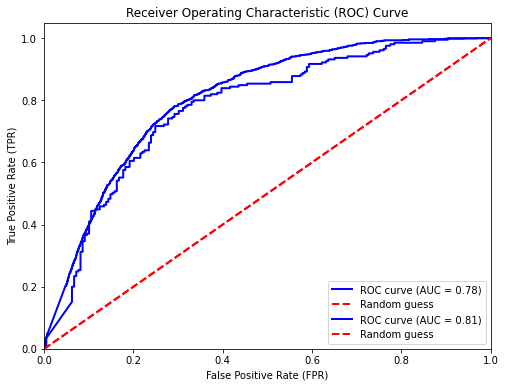

In [110]:
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are the true binary labels and predicted probabilities, respectively

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_binary)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')

fpr, tpr, thresholds = roc_curve(binary_targets, y_binary_all)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


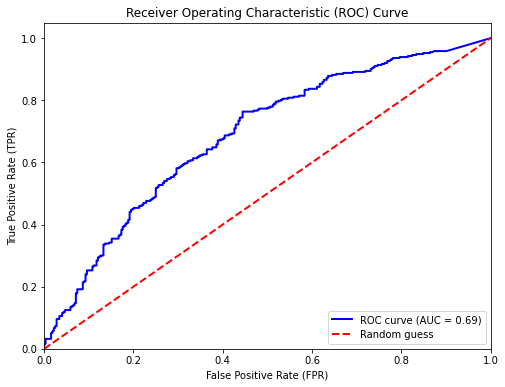

In [573]:
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are the true binary labels and predicted probabilities, respectively

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_binary)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


(array([ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  2.,
         1.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         2.,  1.,  0.,  1.,  2.,  2.,  1.,  2.,  0.,  4.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  2.,  0.,  1.,  2.,  1.,
         0.,  1.,  2.,  1.,  3.,  1.,  1.,  4.,  3.,  1.,  0.,  4.,  0.,
         2.,  1.,  4.,  2.,  5.,  5.,  4.,  4.,  6.,  2., 11., 11., 10.,
        16., 15., 38.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([0.14074272, 0.14922073, 0.15769875, 0.16617677, 0.17465478,
        0.1831328 , 0.19161081, 0.20008883, 0.20856684, 0.21704486,
        0.22552288, 0.23400089, 0.2424789 , 0.25095692, 0.25943494,
        0.26791295, 0.27639097, 0.284869  , 0.293347  , 0.30182502,
        0.31030303, 0.31878105, 0.32725906, 0.33573708, 0.3442151 ,
        0.3526931 , 0.36117113, 0.36964914, 0.37812716, 0.38660517,
        0.3950832 , 0.4035

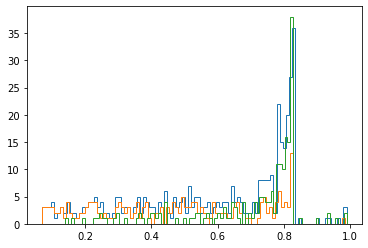

In [111]:
fig, ax = plt.subplots()
ax.hist(y_binary, bins=100, histtype='step')
ax.hist(y_binary[y_test_binary == 0], bins=100, histtype='step')
ax.hist(y_binary[y_test_binary == 1], bins=100, histtype='step')

(0.0, 500.0)

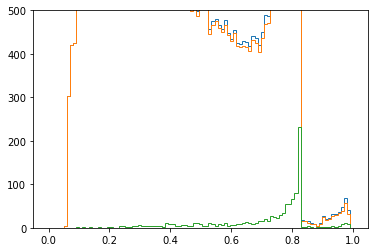

In [112]:
fig, ax = plt.subplots()
total = ax.hist(y_binary_all, bins=np.linspace(0, 1, 100), histtype='step')
bad = ax.hist(y_binary_all[binary_targets == 0], bins=np.linspace(0, 1, 100), histtype='step')
good = ax.hist(y_binary_all[binary_targets == 1], bins=np.linspace(0, 1, 100), histtype='step')
# ax.set_yscale('log')
ax.set_ylim(0, 500)

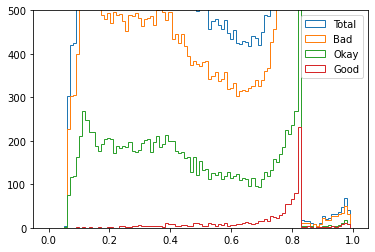

In [234]:
fig, ax = plt.subplots()
total = ax.hist(y_binary_all, bins=np.linspace(0, 1, 100), histtype='step', label='Total')
bad = ax.hist(y_binary_all[binary_targets_okay == 0], bins=np.linspace(0, 1, 100), histtype='step', label='Bad')
okay = ax.hist(y_binary_all[binary_targets_okay == 1], bins=np.linspace(0, 1, 100), histtype='step', label='Okay')
good = ax.hist(y_binary_all[binary_targets == 1], bins=np.linspace(0, 1, 100), histtype='step', label='Good')
# ax.set_yscale('log')
ax.set_ylim(0, 500)
ax.legend()

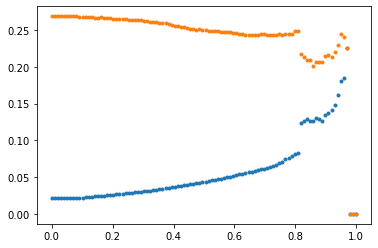

In [235]:
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 100)
ax.plot(bins, [np.sum(np.array(good[0])[bins[:-1]>i])/np.sum(np.array(total[0])[bins[:-1]>i]) if np.sum(np.array(total[0])[bins[:-1]>i])!=0 else 0 for i in bins], '.')
ax.plot(bins, [np.sum(np.array(okay[0])[bins[:-1]>i])/np.sum(np.array(total[0])[bins[:-1]>i]) if np.sum(np.array(total[0])[bins[:-1]>i])!=0 else 0 for i in bins], '.')

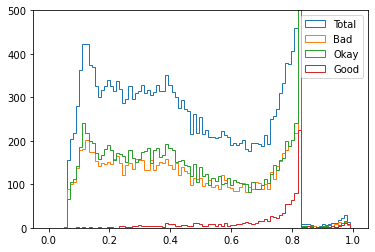

In [231]:
fig, ax = plt.subplots()
total = ax.hist(y_binary_all[counts>0], bins=np.linspace(0, 1, 100), histtype='step', label='Total')
bad = ax.hist(y_binary_all[(binary_targets_okay == 0) & (counts>0)], bins=np.linspace(0, 1, 100), histtype='step', label='Bad')
okay = ax.hist(y_binary_all[(binary_targets_okay == 1) & (counts>0)], bins=np.linspace(0, 1, 100), histtype='step', label='Okay')
good = ax.hist(y_binary_all[(binary_targets == 1) & (counts>0)], bins=np.linspace(0, 1, 100), histtype='step', label='Good')
# ax.set_yscale('log')
ax.set_ylim(0, 500)
ax.legend()

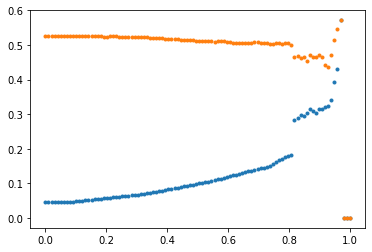

In [233]:
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 100)
ax.plot(bins, [np.sum(np.array(good[0])[bins[:-1]>i])/np.sum(np.array(total[0])[bins[:-1]>i]) if np.sum(np.array(total[0])[bins[:-1]>i])!=0 else 0 for i in bins], '.')
ax.plot(bins, [np.sum(np.array(okay[0])[bins[:-1]>i])/np.sum(np.array(total[0])[bins[:-1]>i]) if np.sum(np.array(total[0])[bins[:-1]>i])!=0 else 0 for i in bins], '.')

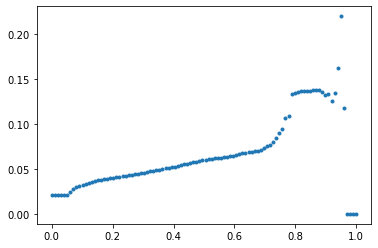

In [503]:
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 100)
ax.plot(bins, [np.sum(np.array(good[0])[bins[:-1]>i])/np.sum(np.array(total[0])[bins[:-1]>i]) if np.sum(np.array(total[0])[bins[:-1]>i])!=0 else 0 for i in bins], '.')

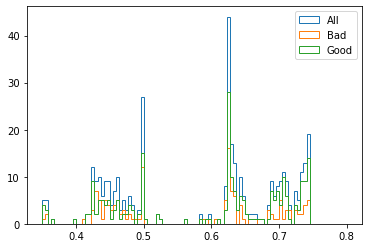

In [575]:
fig, ax = plt.subplots()
ax.hist(y_binary, bins=np.linspace(0.35, .8, 100), histtype='step', label='All')
ax.hist(y_binary[y_test_binary == 0], bins=np.linspace(0.35, .8, 100), histtype='step', label='Bad')
ax.hist(y_binary[y_test_binary == 1], bins=np.linspace(0.35, .8, 100), histtype='step', label='Good')
ax.legend()

(array([35.,  4., 12.,  9., 12.,  4.,  4.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  2.,  9.,  2.,  5.,
         4.,  3.,  7.,  1.,  3.,  2.,  3.,  1.,  3.,  1.,  4.,  2.,  1.,
         2., 10.,  6.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  1.,  0.,  3., 27.,  9.,  8.,  4.,  5.,  4.,  3.,
         1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  4.,  6.,  7.,  2., 11.,
         4.,  6.,  0.,  0.,  3.,  3.,  8.,  6., 19.]),
 array([0.3277847 , 0.33194378, 0.33610287, 0.34026197, 0.34442106,
        0.34858018, 0.35273927, 0.35689837, 0.36105746, 0.36521655,
        0.36937565, 0.37353474, 0.37769383, 0.38185292, 0.38601205,
        0.39017114, 0.39433023, 0.39848933, 0.40264842, 0.4068075 ,
        0.4109666 , 0.4151257 , 0.4192848 , 0.4234439 , 0.427603  ,
        0.4317621 , 0.4359212 , 0.44008029, 0.44423938, 0.44839847,
        0.45255756, 0.4567

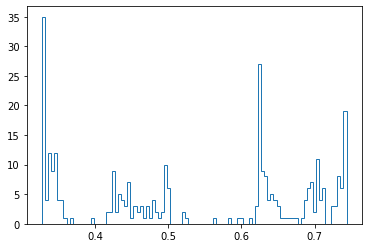

In [576]:
fig, ax = plt.subplots()
# ax.hist(y_binary, bins=100, histtype='step')
# ax.hist(y_binary[y_test_binary == 0], bins=100, histtype='step')
ax.hist(y_binary[y_test_binary == 1], bins=100, histtype='step')

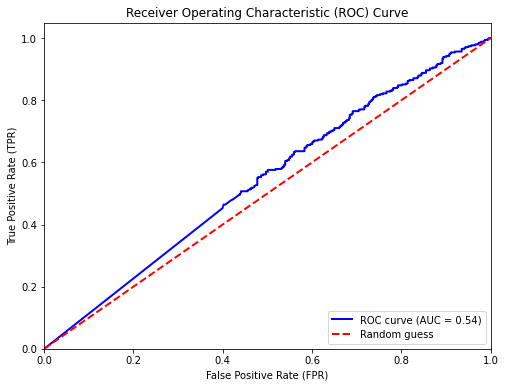

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are the true binary labels and predicted probabilities, respectively

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_binary)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


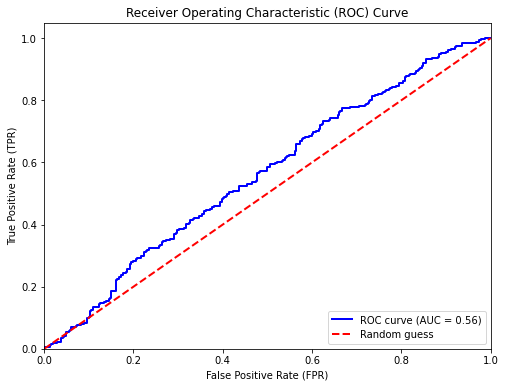

In [41]:
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are the true binary labels and predicted probabilities, respectively

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_binary)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 6.000e+00,
        6.000e+00, 1.800e+01, 4.400e+01, 7.500e+01, 1.430e+02, 4.560e+02,
        1.589e+03, 3.774e+03, 2.028e+03, 5.780e+02, 2.240e+02, 7.800e+01,
        3.500e+01, 1.500e+01, 1.200e+01, 9.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

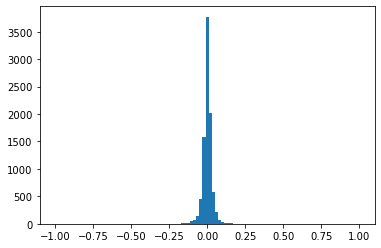

In [77]:
fig, ax = plt.subplots()
ax.hist(y_pred-y_test_pred, bins=np.linspace(-1, 1, 100))

In [78]:
threshold = 0.5

In [79]:
sizes = np.array([((y_test_binary == 1) & (y_binary >= threshold)), ((y_test_binary == 1) & (y_binary < threshold)), ((y_test_binary == 0) & (y_binary >= threshold)), ((y_test_binary == 0) & (y_binary < threshold))])
# print(sizes[0, 0, 0])
sizes = sizes[:, :, 0]
sizes = [i[i==True].size for i in sizes]
print(sizes)
labels = ['made money', 'could have made money', 'lost money', "didn't lose money"]

[3310, 1136, 3310, 1362]


In [80]:
sizes = np.array([((y_test_pred >= 0) & (y_pred >= 0)), ((y_test_pred >= 0) & (y_pred < 0)), ((y_test_pred < 0) & (y_pred >= 0)), ((y_test_pred < 0) & (y_pred < 0))])
# print(sizes[0, 0, 0])
sizes = sizes[:, :, 0]
sizes = [i[i==True].size for i in sizes]
print(sizes)
labels = ['made money', 'could have made money', 'lost money', "didn't lose money"]

[4569, 0, 4549, 0]


In [81]:
both = (y_binary >= threshold) & (y_pred >= 0)

In [82]:
sizes = np.array([((y_test_binary == 1) & (both)), ((y_test_binary == 1) & (~both)), ((y_test_binary == 0) & (both)), ((y_test_binary == 0) & (~both))])
# print(sizes[0, 0, 0])
sizes = sizes[:, :, 0]
sizes = [i[i==True].size for i in sizes]
print(sizes)
labels = ['made money', 'could have made money', 'lost money', "didn't lose money"]

[3310, 1136, 3310, 1362]


([<matplotlib.patches.Wedge at 0x14c9c1760>,
 [Text(0.45889877943206486, 0.9997059118739676, 'made money'),
  Text(-0.981086081676027, 0.4974636673583111, 'could have made money'),
  Text(-0.5352745694789051, -0.9609792585010215, 'lost money'),
  Text(0.981086104963981, -0.49746362143035616, "didn't lose money")])

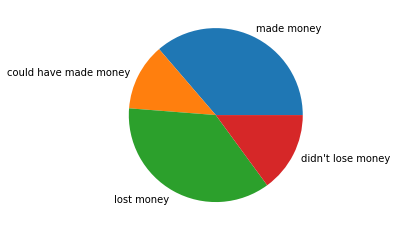

In [83]:
plt.pie(sizes, labels=labels)

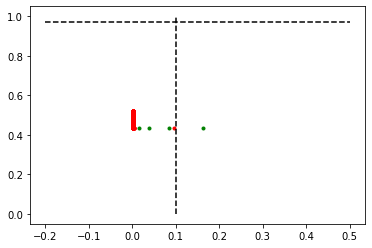

In [85]:
plt.plot(y_pred[y_test_binary>0.5], y_binary[y_test_binary>0.5], '.g')
plt.plot(y_pred[y_test_binary<0.5], y_binary[y_test_binary<0.5], '.r')
plt.plot([0.1]*2, [0, 1], 'k--')
plt.plot([-0.2, 0.5], [0.97]*2, 'k--')

In [49]:
(np.power(10, y_binary)+np.power(10, y_pred/factor))[both_top_10]

NameError: name 'factor' is not defined

5


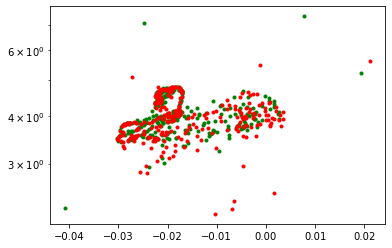

In [50]:
factor = 0.1
plt.plot(y_pred[y_test_binary==1], np.power(10, y_binary[y_test_binary==1]/0.97)+np.power(10, y_pred[y_test_binary==1]/factor), '.g')
plt.plot(y_pred[y_test_binary==0], np.power(10, y_binary[y_test_binary==0]/0.97)+np.power(10, y_pred[y_test_binary==0]/factor), '.r')
plt.yscale('log')
both_top_10 = np.argsort([i[0] for i in np.power(10, y_binary)+np.power(10, y_pred/factor)])[::-1][:10]
print(y_test_binary[both_top_10][y_test_binary[both_top_10]==1].size)

In [ ]:
factor = 0.1
plt.plot(y_binary[y_test_binary==1], np.power(10, y_binary[y_test_binary==1]/0.97)+np.power(10, y_pred[y_test_binary==1]/factor), '.g')
plt.plot(y_binary[y_test_binary==0], np.power(10, y_binary[y_test_binary==0]/0.97)+np.power(10, y_pred[y_test_binary==0]/factor), '.r')
plt.yscale('log')
both_top_10 = np.argsort([i[0] for i in np.power(10, y_binary)+np.power(10, y_pred/factor)])[::-1][:10]
print(y_test_binary[both_top_10][y_test_binary[both_top_10]==1].size)

In [ ]:
pred_model.save('models/pred_model_7000stocks_40by5days_2024_03_02.keras')

In [ ]:
binary_model.save('models/binary_model_7000stocks_40by5days_2024_03_02.keras')

In [ ]:
future[y_fut>0]

In [ ]:
future[y_fut>0].size, future[(y_fut>0) & (future==0)].size 

In [ ]:
future[future==0].size

In [ ]:
targets[targets==0].size

In [ ]:
future[(future == 0) & (targets==0)].size

In [ ]:
mask = [i[0] for i in future == 0]

In [ ]:
fig, ax = plt.subplots()
for i in range(len(data)):
    if mask[i]:
        ax.plot(np.arange(20), (data[i]['Close']-data[i]['Open'])/data[i]['Open'])
        # "print(data[i]['Close'].iloc[-1], data[i]['Open'].iloc[-1])

In [ ]:
net = np.sum(future[y_fut>0])

In [ ]:
net

In [ ]:
net = np.sum(future[y_fut>0])

In [ ]:
net

In [ ]:
(1+net)**200

In [ ]:
net = np.sum(future[(y_fut>0) & (future < .5)])

In [ ]:
net

In [ ]:
(1+net)**200

In [ ]:
y_pred